# BFIC Inquiry Content Category Classification Modeling

부산국제교류재단 문의내용 카테고리 분류 모델링

# 1. 데이터 전처리

## 데이터 프레임 생성

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/국교제/pjt1/1520국교제.csv')

df = df.drop('Unnamed: 0', axis=1)
df.head(3)

In [ ]:
#열 인덱싱
df = df.loc[:, ['분류', '문의내용']]
df

In [ ]:
#행 인덱싱
targets = ['통역','외국인참여프로그램','생활정보','번역','출입국/비자','임금/고용','사법/행정'] #기타'
df = df.loc[df['분류'].isin(targets)]
df.head()
df["분류"].value_counts()

## 범주형변수 -> 수치형 변수

In [ ]:
#특정 열 조건 특정 행 바꾸기

df.loc[(df['분류'] == '통역'), '분류'] = 0
df.loc[(df['분류'] == '외국인참여프로그램'), '분류'] = 1
df.loc[(df['분류'] == '생활정보'), '분류'] = 2
df.loc[(df['분류'] == '번역'), '분류'] = 3
df.loc[(df['분류'] == '출입국/비자'), '분류'] = 4
df.loc[(df['분류'] == '임금/고용'), '분류'] = 5
df.loc[(df['분류'] == '사법/행정'), '분류'] = 6
##df.loc[(df['분류'] == '기타'), '분류'] = 7

## 오탈자 수정

In [ ]:
df['분류'] = pd.to_numeric(df['분류'])
df['문의내용'] = df['문의내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣A-Z0-9/ ]","")
df['문의내용'].replace('', np.nan, inplace=True)
df = df.dropna(how='any')
print(df.isnull().sum())

## 트레인, 테스트 셋 나누기

In [ ]:
train_data, test_data = train_test_split(df, test_size = 0.2, random_state = 42)
print('훈련용 민원의 개수 :', len(train_data))
print('테스트용 민원의 개수 :', len(test_data))

##y에 대한 트레인, 테스트 셋 나누기

train_y, test_y = train_test_split(df['분류'], test_size = 0.25, random_state = 42)
print('훈련용 라벨의 개수 :', len(train_data))
print('테스트용 라벨의 개수 :', len(test_data))


## 불용어 처리

In [ ]:
stopwords = ['문의', '자', '가', '싶', '수', '알', '았', '의', '었', '함', '있', '는지', '은데', '고', '는', '다', '은', '한', '에', '데', '하', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '임', '되', '음', '면']

## 단어 토큰화

In [ ]:
##토큰화
import konlpy
from konlpy.tag import Mecab

mecab = Mecab() 

train_data['tokenized'] = train_data['문의내용'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['문의내용'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

## 정수 인코딩

In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data['분류'].values
X_test= test_data['tokenized'].values
y_test = test_data['분류'].values

## 정수 인코딩
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

#tokenizer.word_index

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카\운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items(): #word_counts : 단어 빈도 수 세기, 예로 의료는 278번 나옴
    total_freq = total_freq + value
    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [ ]:
vocab_size = total_cnt - rare_cnt + 2
print('빈도수 2번 이상 단어 집합의 크기 :',vocab_size)

In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
temp = 0
for i in range(0,len(X_train)):
    if len(X_train[i]) >= 100:
        temp = temp + 1
print('100개 단어 이상 문장의 수 : ', temp)

# 2. 모델링

In [ ]:
import matplotlib.pyplot as pltfrom 
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.preprocessing import sequence
from keras.utils import np_utils
from tensorflow.keras.models import load_model

import numpy
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen = 100)
X_test = pad_sequences(X_test, maxlen = 100)


## 종속변수 데이터 전처리 : 원 핫 인코딩

In [ ]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

## 딥러닝 LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

with tf.device('/device:GPU:0'):


   model = Sequential()

   #Embedding 층은 데이터 전처리 과정을 통해 입력된 값을 받아 다음 층이 알아들을 수 있는 형태로 변환하는 역할을 합니다.
   #여기서는 Embedding('불러온 단어의 총 개수', '기사 당 단어수') 형식
   #모델 설정 부분의 맨 처음에 있어야 합니다.
   model.add(Embedding(vocab_size,100))

   model.add(layers.Activation('tanh'))
   model.add(tf.compat.v1.keras.layers.CuDNNLSTM(128))
   #LSTM(기사당 단어 수, 활성함수) 형태입니다. 활성화 함수로 Tanh
   #model.add(LSTM(100, activation='tanh'))
   model.add(Dense(7, activation='softmax'))
   model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

   es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
   mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)

   history = model.fit(X_train, y_train, batch_size=50, epochs=10, callbacks=[es, mc], validation_data=(X_test, y_test)) # callbacks=[es, mc]

In [ ]:
loaded_model = load_model('best_model.h5')
loaded_model.evaluate(X_test, y_test)

In [ ]:
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

299/299 [==============================] - 3s 10ms/step - loss: 0.4990 - accuracy: 0.8401
테스트 정확도: 0.8401


## 손실과 정확도 곡선

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


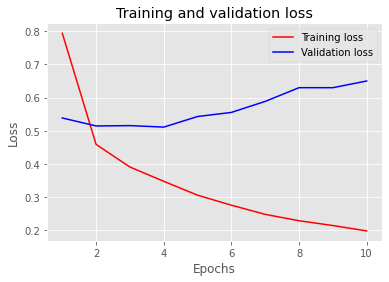

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', color = 'red', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 3. 결과

## 모델을 실제에 대입

In [ ]:
predict = loaded_model.predict(X_test)

predict_labels = np.argmax(predict, axis=1)
original_labels = np.argmax(y_test, axis=1)

for i in range(50):
    print("문의내용 : ", test_data['문의내용'].iloc[i], "/\t 원래 라벨 : ", original_labels[i], "/\t예측한 라벨 : ", predict_labels[i])



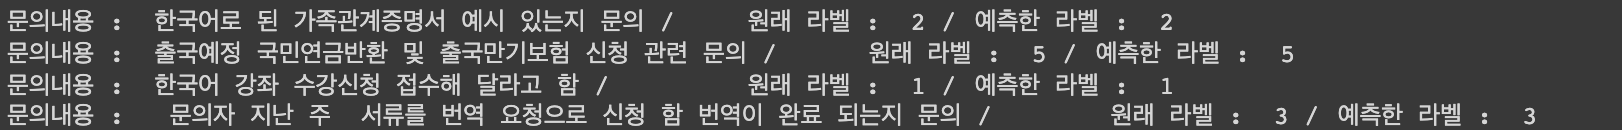

## 모델을 활용하여 문의내용을 입력하면 예측 라벨 생성

In [ ]:
import re


def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣A-Z0-9/ ]','', new_sentence)
    new_sentence = mecab.morphs(new_sentence) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = 100)
    predict = loaded_model.predict(pad_new)
    value1 = np.argmax(predict)
    print(value1, "번 카테고리 입니다.")

In [ ]:
sentiment_predict('일주일 동안 한국어 수업을 온라인 학습터 매뉴얼에서 드릴수 어려워함. 수업을 드릴수 있는 방법을 문의함')

1 번 카테고리 입니다.


In [ ]:
sentiment_predict('일본어를 한국어로 번역 문의')

3 번 카테고리 입니다.


In [ ]:
sentiment_predict('일본어를 한국어로 통역 문의')

0 번 카테고리 입니다.


In [ ]:
sentiment_predict('비자 발급 문의')

4 번 카테고리 입니다.
